# Basic analytical GGOR solution

@TO 2020-05-25

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as dp
import pdb

# paths
python = os.path.expanduser("~/GRWMODELS/python/")
tools = os.path.join(python, "tools/")
GGOR = os.path.join(python, "GGOR/")

sys.path.insert(1, GGOR)
sys.path.insert(1, tools)

from KNMI import knmi
from src import analytic
from src.analytic import ggor_analytical

In [2]:
matplotlib.rc('font', size=20)

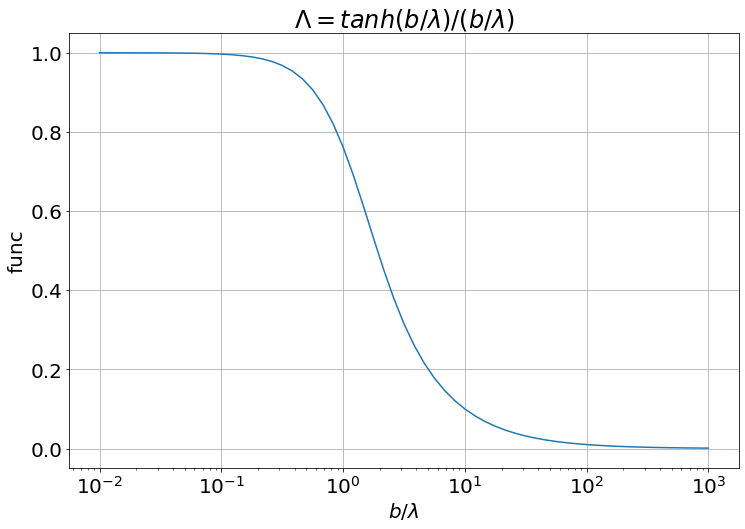

In [3]:
ax = ggor_analytical.newfig('$\Lambda = tanh(b/\lambda)/(b/\lambda)$', '$b/\lambda$', 'func', xscale='log', size_inches=(12, 8))
beta = np.logspace(-2, 3, 61)
ax.plot(beta, np.tanh(beta)/beta, label='tanh(beta)/beta')


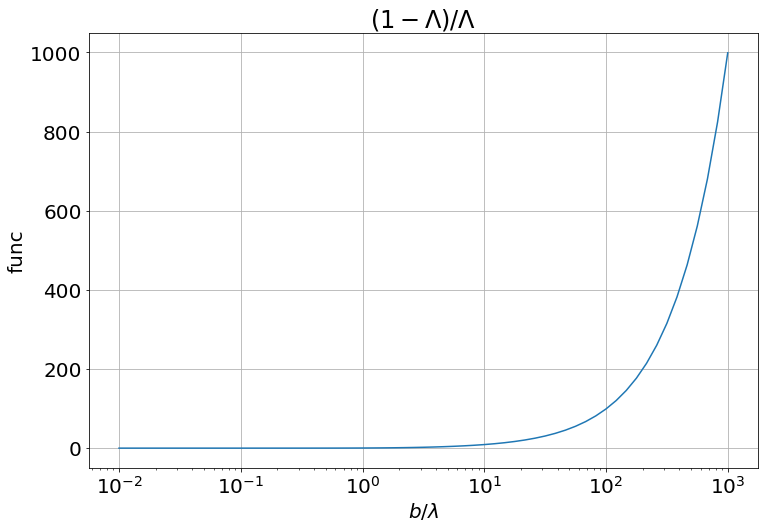

In [4]:
ax = ggor_analytical.newfig('$(1-\Lambda) / \Lambda$', '$b/\lambda$', 'func', xscale='log', size_inches=(12, 8))
beta = np.logspace(-2, 3, 61)
Lam = np.tanh(beta) / beta
ax.plot(beta, (1 - Lam) / Lam, label='tanh(beta)/beta')


# Simulatie

In [5]:
def parcel_plot(parcel):
    """Plot the results for the simulated parcel.
    
    Parameters
    ----------
    parcel: simulated parcel object
    
    Returns
    -------
    None
    
    """
    p = parcel
    da = parcel.data

    # This shows that both solutions yield the same values of w == 0.
    ax = ggor_analytical.newfig2(titles=[f"Head in cross section, solution '{p.name:}'",
                        f"Flows in cross section, solution '{p.name:}'"],
                        xlabel='time', ylabels=['head [m]]', 'Flowss [m/d]'], size_inches=(12, 14))

    ax[0].plot(da.index, da[ 'h1'], 'b', lw=1, label='h1, top layer')
    ax[0].plot(da.index, da['hLR'], 'r', lw=1, label='hLR, ditches')
    ax[0].plot(da.index, da[ 'h2'], 'g', lw=1, label='h2, regional aquifer')
    ax[0].legend(fontsize=10)
    ax[1].plot(da.index, da[ 'N'], 'b', lw=1, label='N, net rechage')
    ax[1].plot(da.index, da['qv'], 'r', lw=1, label='qv, upw. seepage')
    ax[1].plot(da.index, da['qd'], 'g', lw=1, label='qd, to ditches')
    ax[1].plot(da.index, da['qs'], 'm', lw=1, label='qs, to storage')
    ax[1].legend(fontsize='10')
    plt.show()


File <weer240_20100101_20191231.txt> exists, download was skipped.


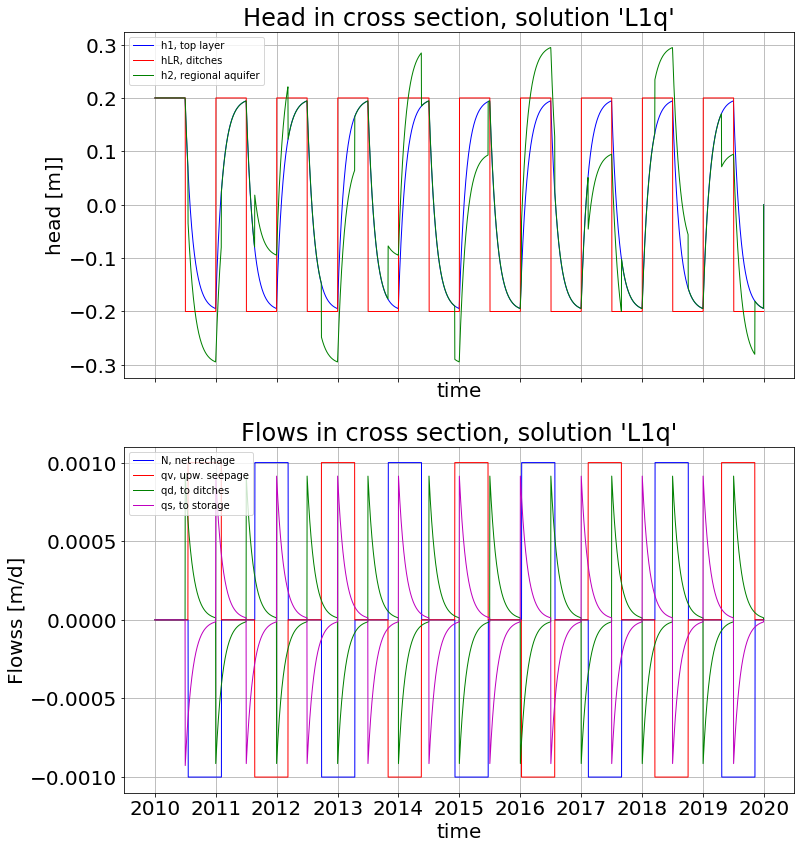

In [6]:
data = knmi.get_weather(stn=240, start='20100101', end='20191231')
ggor_analytical.set_hLR(data=data, props=ggor_analytical.props)

data = ggor_analytical.gen_testdata(data=data,
         N=(200, 0.0, -0.001, 0.0, 0.001),
         hLR=(182.7, 0.2, -0.2),
         q  =(200, 0.0, 0.001, 0.0, -0.001),
         h2 =(90, 0.4, 0.2, 0.15))

# generate solution index pass its properties
parcel1 = ggor_analytical.L1q(props=ggor_analytical.props)
parcel1.sim(data=data)

parcel_plot(parcel1)


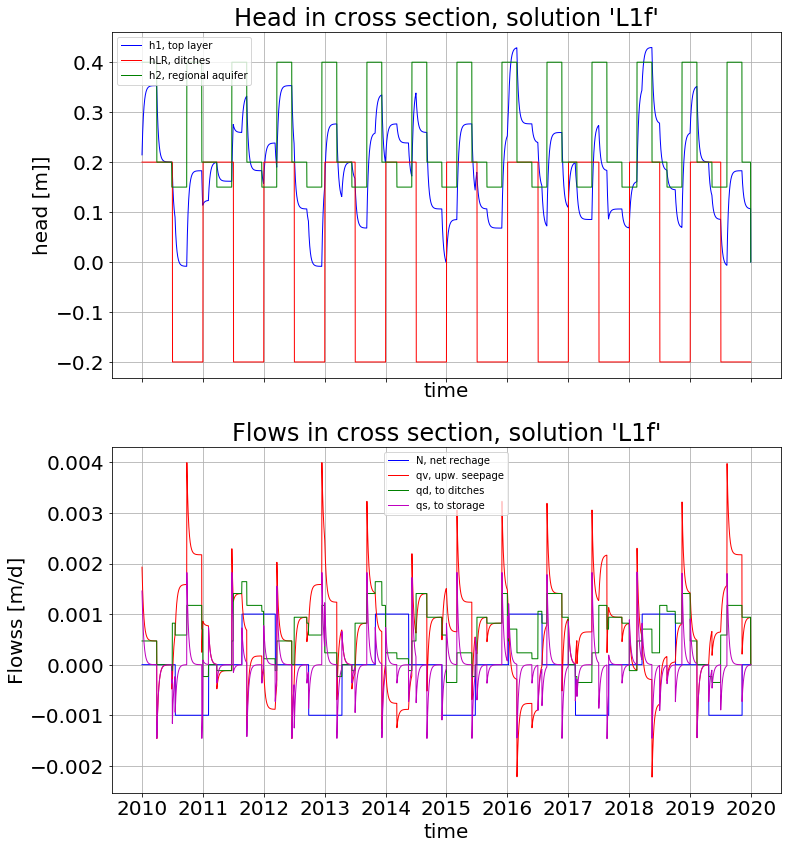

In [7]:
parcel2 = ggor_analytical.L1f(props=ggor_analytical.props)
parcel2.sim(data=data)

parcel_plot(parcel2)